## Load libraries & Declare global variables

In [1]:
import pandas as pd
from neo4j import GraphDatabase
import csv
import sparknlp as sp


JOB_LIST = ["Software Architect", "Bu siness Analyst", "Data Scientist", "Game Development",
            "Database Administrator", "Data Engineer", "Data Analysts","Software Engineer", "Web Development",
            "Devops Engineer", "Network Engineer", "UI Designer", "Tester", "Mobile Developer", "Backend Developer", "Frontend Developer"]
DEFAULT_PATH = "/Users/nguyenvanviet/Work/Courses/DataGen/MyPaperDataSet/JobData/"
COMPETENCIES_LIST = ["Knowledge", "Platform", "Framework", "ProgrammingLanguage", "Tool"]
WEB_LIST = ["Indeed", "CareerBuilder", "Glint"]
FILE_PATH = "data/"

## Connect to Neo4J database

In [2]:

uri = "bolt://localhost:7687"  # Adjust the URI based on your Neo4j server configuration
username = "neo4j"
password = "12345678"

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))
driver

In [121]:
#sp.start()

### Query to data frame function (General Function)

In [3]:
def queryToDataFrame(query):

    with driver.session() as session:
        result = session.run(query)
        columns = result.keys()
        data = [record for record in result]

    return pd.DataFrame(data, columns=columns)


---
# BI Statistics
---

## Get Job Data

In [4]:
### Get max, min Id
def getMinMaxIdOfEntity(entityName):
    query = f"match(n:{entityName}) return min(id(n)) as minId, max(id(n)) as maxId"
    data = queryToDataFrame(query)
    maxId = data["maxId"][0]
    minId = data["minId"][0]
    return minId - 1, maxId + 1

print(getMinMaxIdOfEntity("FactCourse"))

(-1, 4148)


In [124]:
min, max = getMinMaxIdOfEntity("FactJobPosting")
step = 50
## ----------------------------------------------------------------
## for job data without compentency
## ----------------------------------------------------------------



def timeConvert(data):
    if ("Date" not in data.columns): return data
    data['Time'] = data.apply(lambda row: f"{row['Year']}-{row['Month']:02d}-{row['Date']:02d}", axis=1)
    return data.drop(["Date", "Month", "Year" ], axis=1)

    
jobDataFileName = FILE_PATH + "JobDataBI.csv"

jobData = pd.DataFrame()
for i in range(min, max, step):
    jobQuery = f''' match(f: FactJobPosting)-[:Belong_to_career]->(c: Career)
    where id(f) < {i+step} and id(f)> {i}
    match(f)-[:Published_on]->(w:Website)
    match(f)-[:Recruited_by]->(o:Organization)
    match(f)-[:Posted_at_time]->(d:Date)-[:Part_of]->(m:Month)-[:Part_of]->(y:Year)
    match(f)-[:Located_at]->(l: Location)
    return f.totalJobPost as JobCount, c.name as Career, l.location as Location, o.name as Organization,
        w.name as Web,  d.day as Date, m.month as Month, y.year as Year 
 '''
    jobDataTemp= queryToDataFrame(jobQuery)
    jobData = pd.concat([jobData, jobDataTemp], ignore_index=True, sort=False)
    print(f"Loading process {(i-min)/(max-min) * 100} %", end='\r')


jobData = timeConvert(jobData)
jobData.to_csv(jobDataFileName, index=False)
jobData.head(10)



,JobCount,Career,Location,Organization,Web,Time
0,3,Database Administrator,"Saint Louis Park, MN 55416 (Wolfe Park area)",AAA Minneapolis,Indeed,2024-01-14
1,1,Database Administrator,Georgia,ADPMN IT SOLUTIONS,Indeed,2024-01-14
2,1,Frontend Developer,"Austin, TX","ADS, Inc.",Indeed,2024-01-14
3,1,Mobile Developer,"Austin, TX","ADS, Inc.",Indeed,2024-01-14
4,1,Database Administrator,United States,ALT America,Indeed,2024-01-14
5,1,Business Analyst,Hồ Chí Minh,ACB - Ngân Hàng TMCP Á Châu,CareerBuilder,2024-01-08
6,3,Backend Developer,Singapore,ANOTECH Singapore,Glint,2024-01-11
7,3,Data Engineer,Singapore,ANOTECH Singapore,Glint,2024-01-11
8,3,Devops Engineer,Singapore,ANOTECH Singapore,Glint,2024-01-11
9,1,Software Architect,"Remote in Dimondale, MI",ARK Solutions,Indeed,2024-01-14


In [125]:
## ----------------------------------------------------------------
## for jobData AND course data with competency
## ----------------------------------------------------------------


def compeStatistics(factName, compeName):
    compeAttr = compeName[:1].lower() + compeName[1:] 

    returnList = ""
    otherMatch = ""
    relationShip = ""

    if (factName == "FactJobPosting"):
        returnList = "f.totalJobPost as JobCount, d.day as Date, m.month as Month, y.year as Year "
        relationShip = f"Required_{compeAttr}"
        otherMatch = "match(f)-[:Posted_at_time]->(d:Date)-[:Part_of]->(m:Month)-[:Part_of]->(y:Year)"

    elif (factName == "FactCourse"):
        returnList = "f.enroll as Enroll, f.rating as Rate, c.level as Level, count(c) as NumberOfCourse"
        otherMatch = "match(f)-[:Belong_to_course]->(c: Course)"
        relationShip = f"Taught_{compeAttr}"


    compeQuery = f''' match(f: {factName})
            match(f)-[:{relationShip}]->(cpt : {compeName})
            {otherMatch}
            return {returnList}, 
                cpt.{compeAttr} as {compeName}
        '''
    return queryToDataFrame(compeQuery)

for fact in ["FactCourse", "FactJobPosting"]:
    print(fact)
    for com in COMPETENCIES_LIST:
        plCompe = compeStatistics(fact, com)
        plCompe = timeConvert(plCompe)    
        plCompe.to_csv(FILE_PATH + com + fact + ".csv", index=False)

FactCourse
FactJobPosting


## Load course to csv

In [126]:
min, max = getMinMaxIdOfEntity("FactCourse")
step = 50
fileName = FILE_PATH + "courseDataBI.csv"
data = pd.DataFrame()
for i in range(min, max, step):
    jobQuery = f''' match(f: FactCourse)-[:Belong_to_course]->(c: Course)
    where id(f) < {i+step} and id(f)> {i}
    match(f)-[:Posted_on]->(w:Website)
    match(f)-[:Belong_to]->(o:Organization)
    match(c)-[:Taught_by]->(i: Instructor)
    return c.name as CourseName, c.link as CourseLink, c.level as CourseLevel, c.duration as CourseDuration, c.price as CoursePrice, 
        f.enroll as Enroll, f.rating as Rate, o.name as Organization, w.name as Website, w.url as LinkToWebsite
 '''
    dataTemp= queryToDataFrame(jobQuery)
    data = pd.concat([data, dataTemp], ignore_index=True, sort=False)
    print(f"Loading process {(i-min)/(max-min) * 100} %", end='\r')

data.to_csv(fileName, index=False)
data.head(10)

,CourseName,CourseLink,CourseLevel,CourseDuration,CoursePrice,Enroll,Rate,Organization,Website,LinkToWebsite
0,Introduction to Data Engineering,https://www.coursera.org/learn/introduction-to...,Basic,11.0,0.0,19,4.7,IBM,coursera,www.coursera.org
1,Data Engineering and Machine Learning using Spark,https://www.coursera.org/learn/data-engineerin...,Basic,7.0,0.0,1,3.7,IBM,coursera,www.coursera.org
2,Cloud Data Engineering,https://www.coursera.org/learn/cloud-data-engi...,Intermediate,17.0,0.0,1,4.5,Duke University,coursera,www.coursera.org
3,Cloud Data Engineering,https://www.coursera.org/learn/cloud-data-engi...,Intermediate,17.0,0.0,1,4.5,Duke University,coursera,www.coursera.org
4,Modernizing Data Lakes and Data Warehouses wit...,https://www.coursera.org/learn/data-lakes-data...,Intermediate,9.0,0.0,33,4.7,Google Cloud,coursera,www.coursera.org
5,Explore Core Data Concepts in Microsoft Azure,https://www.coursera.org/learn/explore-core-da...,Basic,9.0,0.0,3,4.8,Microsoft,coursera,www.coursera.org
6,AI Workflow: Business Priorities and Data Inge...,https://www.coursera.org/learn/ibm-ai-workflow...,Intermediate,8.0,0.0,4,4.3,IBM,coursera,www.coursera.org
7,Introduction to Data Engineering,https://www.coursera.org/learn/introduction-to...,Basic,11.0,0.0,19,4.7,IBM,coursera,www.coursera.org
8,Introduction to Data Analytics,https://www.coursera.org/learn/introduction-to...,Basic,11.0,0.0,120,4.8,IBM,coursera,www.coursera.org
9,Introduction to NoSQL Databases,https://www.coursera.org/learn/introduction-to...,Basic,17.0,0.0,3,4.6,IBM,coursera,www.coursera.org


In [47]:
data.groupby("CourseName").describe()

Duration                   \
                                                      count  mean  std   min   
CourseName                                                                     
3D Data Visualization for Science Communication         4.0  32.0  0.0  32.0   
70-462: Microsoft SQL Server Database Administr...      4.0  -1.0  0.0  -1.0   
A Beginners Guide to Exadata Patching for Oracl...      3.0  -1.0  0.0  -1.0   
A Crash Course in Data Science                          3.0   7.0  0.0   7.0   
AI Workflow: Business Priorities and Data Inges...    202.0   8.0  0.0   8.0   
...                                                     ...   ...  ...   ...   
Wordpress Sliders                                       1.0   1.5  NaN   1.5   
Wrangling Data in the Tidyverse                         1.0  14.0  NaN  14.0   
Writing Requirements for IT � Simply Put!               1.0  -1.0  NaN  -1.0   
[Intermediate] Spatial Data Analysis with R, QG...      3.0   5.0  0.0   5.0   
introduction to software testing ???????                1.0   1.0  NaN   1.0   

                                                                            \
                                                     25%   50%   75%   max   
CourseName                                                                   
3D Data Visualization for Science Communication     32.0  32.0  32.0  32.0   
70-462: Microsoft SQL Server Database Administr...  -1.0  -1.0  -1.0  -1.0   
A Beginners Guide to Exadata Patching for Oracl...  -1.0  -1.0  -1.0  -1.0   
A Crash Course in Data Science                       7.0   7.0   7.0   7.0   
AI Workflow: Business Priorities and Data Inges...   8.0   8.0   8.0   8.0   
...                                                  ...   ...   ...   ...   
Wordpress Sliders                                    1.5   1.5   1.5   1.5   
Wrangling Data in the Tidyverse                     14.0  14.0  14.0  14.0   
Writing Requirements for IT � Simply Put!           -1.0  -1.0  -1.0  -1.0   
[Intermediate] Spatial Data Analysis with R, QG...   5.0   5.0   5.0   5.0   
introduction to software testing ???????             1.0   1.0   1.0   1.0   

                                                    Price         ...         \
                                                    count   mean  ...    75%   
CourseName                                                        ...          
3D Data Visualization for Science Communication       4.0   0.00  ...   0.00   
70-462: Microsoft SQL Server Database Administr...    4.0  -1.00  ...  -1.00   
A Beginners Guide to Exadata Patching for Oracl...    3.0  -1.00  ...  -1.00   
A Crash Course in Data Science                        3.0   0.00  ...   0.00   
AI Workflow: Business Priorities and Data Inges...  202.0   0.00  ...   0.00   
...                                                   ...    ...  ...    ...   
Wordpress Sliders                                     1.0  13.99  ...  13.99   
Wrangling Data in the Tidyverse                       1.0   0.00  ...   0.00   
Writing Requirements for IT � Simply Put!             1.0  -1.00  ...  -1.00   
[Intermediate] Spatial Data Analysis with R, QG...    3.0  13.99  ...  13.99   
introduction to software testing ???????              1.0  13.99  ...  13.99   

                                                            Rate       \
                                                      max  count mean   
CourseName                                                              
3D Data Visualization for Science Communication      0.00    4.0  0.0   
70-462: Microsoft SQL Server Database Administr...  -1.00    4.0  4.5   
A Beginners Guide to Exadata Patching for Oracl...  -1.00    3.0  3.8   
A Crash Course in Data Science                       0.00    3.0  4.5   
AI Workflow: Business Priorities and Data Inges...   0.00  202.0  4.3   
...                                                   ...    ...  ...   
Wordpress Sliders                                   13.99  

## Upload csv to GG drive

In [127]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

drive = GoogleDrive(gauth)



def getFolderIdByName(drive, folderName):
    # """Search for a folder by name and return its ID."""
    query = f"title = '{folderName}' and mimeType = 'application/vnd.google-apps.folder' and trashed=false"
    folderList = drive.ListFile({'q': query}).GetList()
    if folderList:
        # Assuming the first match is the folder you want
        return folderList[0]['id']
    else:
        print(f"No folder found with the name: {folderName}")
        return None

def upLoadToDrive(csvFileName, folderName=None):
    # get id of gg drive folder
    folderId = getFolderIdByName(drive, folderName) if folderName else None

    # find file name in the above folder
    titleFile = csvFileName[:len(csvFileName)-4]
    query = f"title='{os.path.basename(titleFile)}' and trashed=false"
    if folderId:
        query += f" and '{folderId}' in parents"

    # Search for files that match the query
    fileList = drive.ListFile({'q': query}).GetList()
    # Check if a file with the same name exists
    if fileList:
        # Assuming the first match is the file you want to update
        file_id = fileList[0]['id']
        file = drive.CreateFile({'id': file_id})
        file.SetContentFile(csvFileName)
        file.Upload({'convert': True})
        print(f'Updated existing Google Sheets file with title: {file["title"]} in folder: {folderName if folderName else "root"}')
    else:
        # No existing file found, proceed to upload a new file
        file_metadata = {
            'title': os.path.basename(csvFileName),
            'parents': [{'id': folderId}] if folderId else []
        }
        upload_file = drive.CreateFile(file_metadata)
        upload_file.SetContentFile(csvFileName)
        upload_file.Upload({'convert': True})
        print(f'Uploaded and converted new file to Google Sheets with title: {upload_file["title"]} to folder: {folderName if folderName else "root"}')




### Upload csv

In [ ]:
GGDRIVE_FOLDER_NAME = 'ThesisData'

import os

# Specify the directory you want to list files from
directory = 'data'

def uploadDataToGGDrive(directory):
    # Loop through the directory
    for filename in os.listdir(directory):
        # Construct full file path
        filepath = os.path.join(directory, filename)
        # Check if it is a file
        if os.path.isfile(filepath):
            upLoadToDrive(filepath, GGDRIVE_FOLDER_NAME)


uploadDataToGGDrive(directory)
print("upload successful")


Updated existing Google Sheets file with title: PlatformFactJobPosting in folder: ThesisData
Updated existing Google Sheets file with title: KnowledgeFactJobPosting in folder: ThesisData
Updated existing Google Sheets file with title: ProgrammingLanguageFactJobPosting in folder: ThesisData
Updated existing Google Sheets file with title: FrameworkFactJobPosting in folder: ThesisData
Updated existing Google Sheets file with title: ProgrammingLanguageFactCourse in folder: ThesisData
Updated existing Google Sheets file with title: ToolFactJobPosting in folder: ThesisData
Updated existing Google Sheets file with title: KnowledgeFactCourse in folder: ThesisData
Updated existing Google Sheets file with title: JobDataBI in folder: ThesisData
Updated existing Google Sheets file with title: FrameworkFactCourse in folder: ThesisData
Updated existing Google Sheets file with title: courseDataBI in folder: ThesisData
Updated existing Google Sheets file with title: ToolFactCourse in folder: ThesisDat

## Upload data to google sheet automatically

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import time


def uploadToBI(data, ggSheetName):
    # Define the scope
    scope = [
        'https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive'
    ]

    # Add credentials to the account
    creds = ServiceAccountCredentials.from_json_keyfile_name('thesisKey.json', scope)

    # Authorize the clientsheet 
    client = gspread.authorize(creds)

    # # List all the spreadsheets accessible by the service account
    # for spreadsheet in client.openall():
    #     print(spreadsheet.title)


    # # Open the sheet
    sheet = client.open(ggSheetName).sheet1  # Change to your Google Sheet name


    # Convert DataFrame to a list of lists
    rows = data.values.tolist()

    print(len(rows))
    # Update sheet with rows
    for i, row in enumerate(rows, start=2):  # Assuming first row is the header in the sheet
        sheet.insert_row(row, i)
        print(f"Uploading process {i/len(rows)* 100} %", end='\r')
        time.sleep(2)



---
# 7 Requirements process phase
---

### Visualization Functions 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def visualization(data, groupByCols, numberOfColumnDisplay, title, figSize, colorHex):
    # Group by 'jobType' and calculate the count of rows for each group
    newData = data
    if (groupByCols is not None and len(groupByCols) > 0): 
        newData = data[groupByCols].value_counts()

    # Select only the top 5 job types
    numberOfCol = newData.reset_index(drop= True)
    numberOfCol = newData.set_index(newData.columns[0]).head(numberOfColumnDisplay)

    # Plotting the bar chart
    ax = numberOfCol.plot(kind='bar', color=colorHex, edgecolor='black', figsize=figSize)

    # Adding labels and title
    plt.xlabel(newData.columns[0])
    plt.ylabel(newData.columns[1])
    plt.title(title)

    # Annotate each bar with the count on top
    for i, v in enumerate(numberOfCol[newData.columns[1]]):
        ax.text(i, v , str(v), ha='center', va='bottom')

    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()

def visualizationMulti(data, numberOfColumnDisplay, title):

    df = data.head(numberOfColumnDisplay)
    # Initialize the matplotlib figure
    plt.figure(figsize=(14, 8))

    # The x locations for the groups
    ind = np.arange(len(df))  
    width = 0.15  # the width of the bars

    labels = []
    # Plot each pair
    for i in range(0, 10, 2):
        category = df.columns[i]
        labels.append("Top "+ str(int(i/2 + 1)))
        values = df.columns[i + 1]

        # Calculate the position for each bar
        position = ind + (i / 2) * width
        bars = plt.bar(position, df[values], width, label=category)

        # Add text for the name of each value on top of the columns
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., 1.01*height,
                     '%s' % (df.loc[bar.get_y(), category]), ha='center', va='bottom', rotation=60)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.xlabel('Categories')
    plt.ylabel('Number of Jobs')
    plt.title('Top Jobs recruitment by competency')
    plt.xticks(ind + width* 2, labels)  # Adjust this if you want to show different labels
    plt.legend()

    # Rotate the x labels slightly
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

### Support Functions

In [5]:
def toUpperList(list):
    if type(list) == str:
        return "\"" + list.upper() + "\""
    upperList =  '[' + ', '.join(f'"{item.strip().upper()}"' for item in list) + ']'

    return upperList

def emptyProcess(data, column):
    for col in column:

        
        data[col] = data[col].apply(lambda x: None if x == [] else x)
    return data

In [46]:
test = "as; asd ; as2; as3"
t = test.split(";")
print(toUpperList(t))


["AS", "ASD", "AS2", "AS3"]


---
## Analyst and statistic group (YC 1-2-3)
---

**Yêu cầu 1:** Trong ngành CNTT, vị trí (nghề nghiệp) nào đang được tuyển dụng nhiều nhất. <br>
-  ***Giải pháp:*** Đối với yêu cầu thống kê này, chúng em tiến hành đếm các bài đăng tuyển dụng có trong DW và gom nhóm lại theo nghề nghiệp, sau đó sắp xếp theo thứ tự giảm dần. Tuy nhiên vì số lượng bài đăng đã được tổng hợp theo các chiều của bảng  factJobPosting cho nên, thay vì đếm thì trong trường hợp này, chúng em sử dụng phép tổng để tính toán các bài đăng có trong DW theo chiều nghề nghiệp. Hình 8.4 thể hiện câu truy vấn dùng để giải quyết yêu cầu trên, hình 8.5 thể hiện kết quả trả về.
-  ***query2:*** match(f:FactJobPosting)-[:Belong_to_career]->(p:Career) return p.name as Career, sum(f.totalJobPost	) as `number of job` order by `number of job` desc
  
Trực quan hoá kết quả


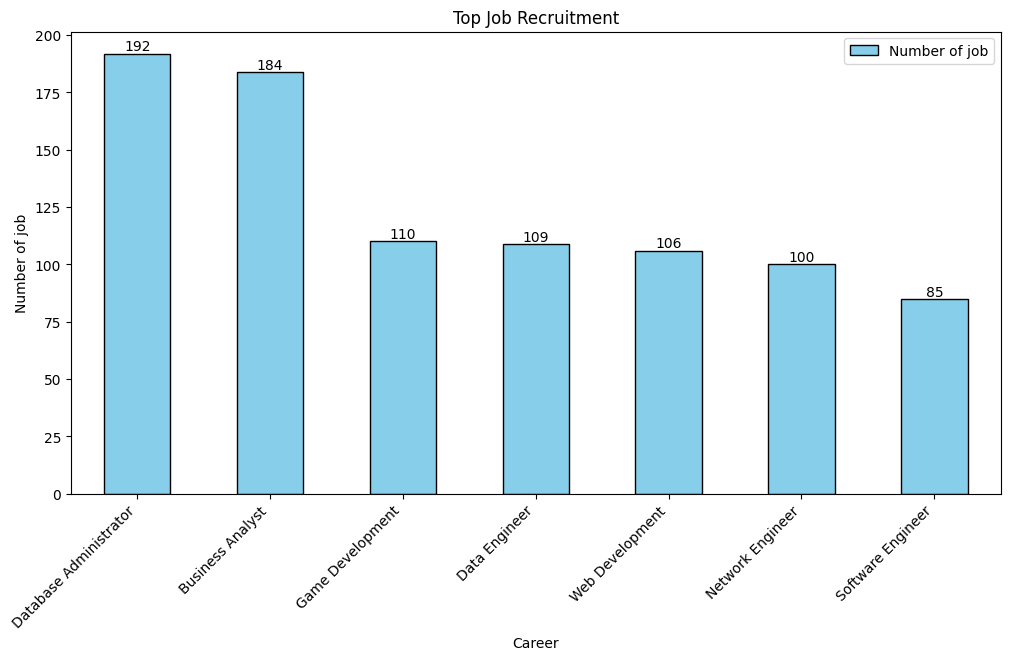

In [8]:
query1 = "match(f:FactJobPosting)-[:Belong_to_career]->(p:Career) return p.name as Career, sum(f.totalJobPost) as `Number of job` order by `Number of job` desc"
query1DF = queryToDataFrame(query1)
visualization(query1DF, None, 7, "Top Job Recruitment", (12, 6), "skyblue")

**Yêu cầu 2:** Những kỹ năng nào đang được tuyển dụng nhiều nhất.
- ***Giải pháp:*** Đối với yêu cầu này, chúng em tiến hành đếm các bài đăng tuyển dụng có trong DW mà có yêu cầu các kỹ năng tương ứng, sau đó sắp xếp theo thứ tự giảm dần. Tuy nhiên, như đã giải thích ở trên vì số lượng bài đăng đã được tổng hợp theo các chiều của bảng  factJobPosting  cho nên trong trường hợp này, chúng em sẽ sử dụng phép tổng để tính toán. 
- ***query:*** match(f:FactJobPosting)-[:Required_programmingLanguage]->(p:ProgrammingLanguage) return p.programmingLanguage as `Programming Language`, sum(f.totalJobPost) as `number of job`

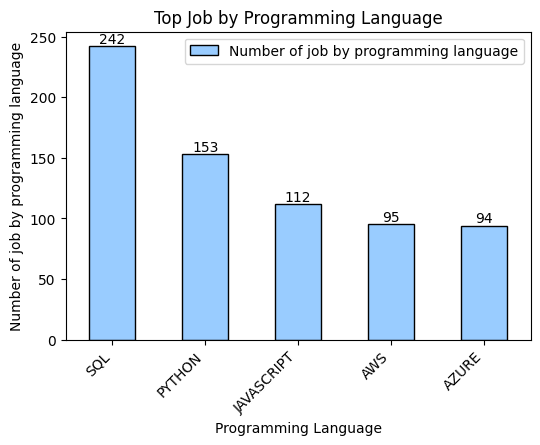

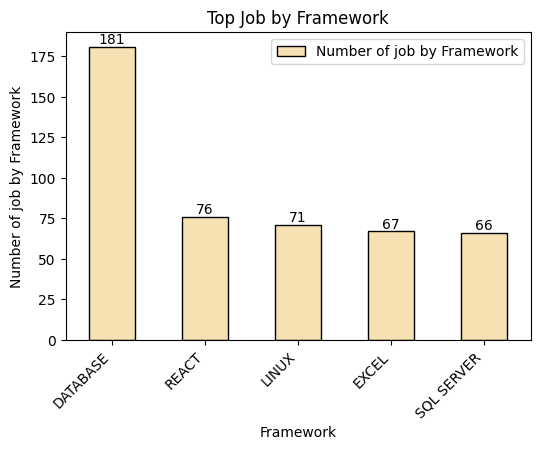

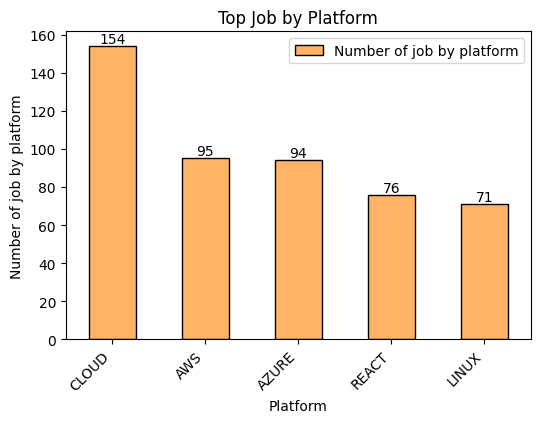

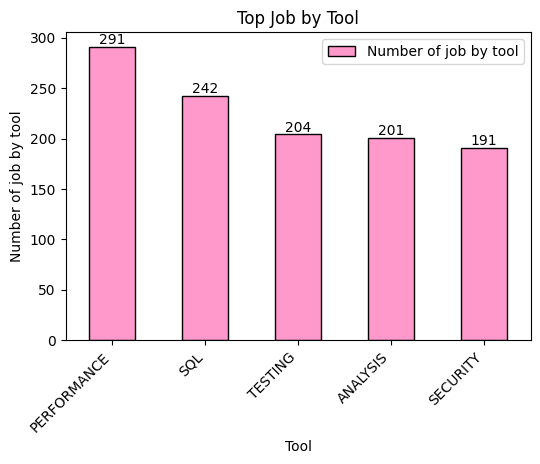

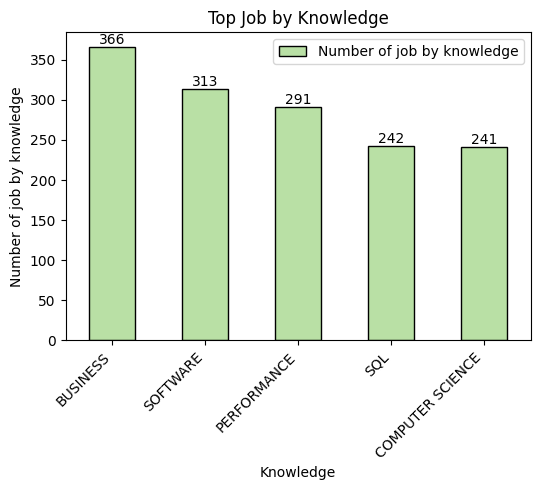

In [8]:
queryPL = "match(f:FactJobPosting)-[:Required_programmingLanguage]->(p:ProgrammingLanguage) return p.programmingLanguage as `Programming Language`, sum(f.totalJobPost) as `Number of job by programming language` order by `Number of job by programming language` desc"
queryFW = "match(f:FactJobPosting)-[:Required_framework]->(p:Framework) return p.framework as Framework, sum(f.totalJobPost) as `Number of job by Framework` order by `Number of job by Framework` desc"
queryPF = "match(f:FactJobPosting)-[:Required_platform]->(p:Platform) return p.platform as Platform, sum(f.totalJobPost) as `Number of job by platform` order by `Number of job by platform` desc"
queryTL = "match(f:FactJobPosting)-[:Required_tool]->(p:Tool) return p.tool as Tool, sum(f.totalJobPost) as `Number of job by tool` order by `Number of job by tool` desc"
queryKL = "match(f:FactJobPosting)-[:Required_knowledge]->(p:Knowledge) return p.knowledge as Knowledge, sum(f.totalJobPost) as `Number of job by knowledge` order by `Number of job by knowledge` desc"

queryPLDF = queryToDataFrame(queryPL).head(5)
queryFWDF = queryToDataFrame(queryFW).head(5)
queryPFDF = queryToDataFrame(queryPF)
queryTLDF = queryToDataFrame(queryTL)
queryKLDF = queryToDataFrame(queryKL)

visualization(queryPLDF, None, 5, "Top Job by Programming Language", (6, 4), "#99CCFF")
visualization(queryFWDF, None, 5, "Top Job by Framework", (6, 4), "#F5E1B2")
visualization(queryPFDF, None, 5, "Top Job by Platform", (6, 4), "#FFB366")
visualization(queryTLDF, None, 5, "Top Job by Tool", (6, 4), "#FF99CC")
visualization(queryKLDF, None, 5, "Top Job by Knowledge", (6, 4), "#B9E0A5")



**Yêu cầu 3:**  Những kỹ năng cần có trong một nghề nghiệp nhất định
- ***Giải pháp:*** Đối với yêu cầu này, đầu tiên với từng nghề nghiệp chúng em tiến hành tìm ra tất cả các kỹ năng yêu cầu. Sau đó đếm số lần xuất hiện của từng kỹ năng. Và tính phần trăm tần suất sử dụng của kỹ năng đó đối với nghề nghiệp tương ứng. Sau đó tiến hành sắp xếp theo phần trăm giảm dần, nhằm nhấn mạnh những kỹ năng quan trọng.
- ***Query:*** Match(f:FactJobPosting)-[:Belong_to_career]->(c:Career)
where c.name = "Data Engineer"
OPTIONAL MATCH (f)-[:Required_knowledge]-> (kl:Knowledge)
OPTIONAL MATCH (f)-[:Required_programmingLanguage]-> (pl:ProgrammingLanguage)
OPTIONAL MATCH (f)-[:Required_framework]-> (fw:Framework)
OPTIONAL MATCH (f)-[:Required_platform]-> (pf:Platform)
OPTIONAL MATCH (f)-[:TEACH_FRAMERequired_toolWORK]-> (tl:Tool)
return collect(pl.programmingLanguage) as ProgrammingLanguage, collect(kl.knowledge) as Knowledge,
collect(fw.framework) as Framework, collect(pf.platform) as Platform, collect(tl.tool) as Tool, c.name as CareerName

    match(f:FactJobPosting)-[:Belong_to_career]->(c:Career) where c.name = \"{careerName}\"  return  sum(f.totalJobPost	) 

In [6]:
careerName = "Data Engineer"

def getQueryForQ3(careerName, relationship, compeName):

    nodeAttr = compeName[:1].lower() + compeName[1:]

    query3_1 = f'''Match(f:FactJobPosting)-[:Belong_to_career]->(c:Career)
    where c.name = \"{careerName}\"
    OPTIONAL MATCH (f)-[:{relationship}]-> (n:{compeName})
    return distinct n.{nodeAttr} as {compeName}, count(n.{nodeAttr}) as Count'''
    return query3_1

query3_2 = f"match(f:FactJobPosting)-[:Belong_to_career]->(c:Career) where c.name = \"{careerName}\"  return  sum(f.totalJobPost) as numJob"
totalJob = queryToDataFrame(query3_2)
totalJobCount = totalJob['numJob'][0]

def getFrequencyCompe(careerName, relationship, compeName):

    query3_1 = getQueryForQ3(careerName, relationship, compeName)

    compeList = queryToDataFrame(query3_1)

    compeList.dropna(inplace=True)
    compeList = compeList.sort_values(by='Count', ascending=False)
    compeList['Frequency'] = round((compeList['Count']/totalJobCount) * 100, 2)
    compeList.drop('Count', axis=1, inplace=True)

    
    return compeList.reset_index(drop=True)


def getCompeFrequencyForJob(careerName):
    res1 = getFrequencyCompe("Data Engineer", "Required_programmingLanguage", "ProgrammingLanguage")
    res2 = getFrequencyCompe("Data Engineer", "Required_framework", "Framework")
    res3 = getFrequencyCompe("Data Engineer", "Required_platform", "Platform")
    res4 = getFrequencyCompe("Data Engineer", "Required_knowledge", "Knowledge")
    res5 = getFrequencyCompe("Data Engineer", "Required_tool", "Tool")

    res = pd.concat([res1, res2, res3, res4, res5], axis=1)

    return res

res = getCompeFrequencyForJob(careerName)
res.head(10)





,ProgrammingLanguage,Frequency,Framework,Frequency,Platform,Frequency,Knowledge,Frequency,Tool,Frequency
0,SQL,35.78,SPARK,19.27,CLOUD,22.94,SQL,35.78,SQL,35.78
1,PYTHON,24.77,DATABASE,16.51,SPARK,19.27,BUSINESS,27.52,CLOUD,22.94
2,SPARK,19.27,HADOOP,14.68,AWS,16.51,ETL,21.10,ETL,21.10
3,AWS,16.51,MYSQL,10.09,HADOOP,14.68,DATA PIPELINES,20.18,DATA PIPELINES,20.18
4,HADOOP,14.68,BIG DATA,9.17,AIRFLOW,12.84,ANALYTICS,19.27,ANALYTICS,19.27
5,KAFKA,11.93,TABLEAU,8.26,KAFKA,11.93,SPARK,19.27,DATA ENGINEERING,17.43
6,MYSQL,10.09,DATA ANALYSIS,8.26,MYSQL,10.09,COMPUTER SCIENCE,18.35,DATABASE,16.51
7,JAVA,9.17,GIT,6.42,AZURE,9.17,DATA ENGINEERING,17.43,ANALYSIS,14.68
8,SCALA,9.17,BUSINESS INTELLIGENCE,5.50,DATA ANALYSIS,8.26,SOFTWARE,17.43,PERFORMANCE,14.68
9,AZURE,9.17,JIRA,4.59,HIVE,8.26,DATABASE,16.51,SECURITY,11.93


In [92]:
query = f'''Match(f:FactJobPosting)-[:Belong_to_career]->(c:Career) 
        where c.name = \"{careerName}\"
        match(f)-[:Required_programmingLanguage]->(pl : ProgrammingLanguage)
        optional match(pl)-[:Have_framework]->(fw: Framework)
        optional match(pl)-[:Use_tool]->(tl: Tool)
        optional match(pl)-[:Relate_to_knowledge]->(kl: Knowledge)
        optional match(fw)-[:Deploy_to_platform]->(pf: Platform)
        return pl.programmingLanguage as ProgrammingLanguage, 
            fw.framework as Framework,
            kl.knowledge as Knowledge, tl.tool as Tool, 
            pf.platform as Platform,
            sum(f.totalJobPost) as jobCount
    '''
dataTest = queryToDataFrame(query)
dataTest = dataTest.sort_values('jobCount', ascending=False)
#dataTest.to_csv("hotCompetency.csv")


In [93]:
dataTest = dataTest.drop_duplicates(['ProgrammingLanguage','Framework', 'jobCount'])
dataTest.head(10)

,ProgrammingLanguage,Framework,Knowledge,Tool,Platform,jobCount
49428,PYTHON,SPARK,BIG DATA,JUPYTER NOTEBOOKS,None,160
49411,PYTHON,PANDAS,STATISTICAL,SAS,None,128
49476,PYTHON,HADOOP,SOFTWARE ARCHITECTURE,JUPYTER NOTEBOOKS,None,128
19037,JAVA,SPARK,GOOGLE MAPSAPI,GEOFENCING APP,None,65
52364,SQL,REST HYBRID FRAMEWORK,FILE CACHE,ANDROID SUPPORT�V4,None,45
52586,SQL,ANDROID GRAPHICS,DATA WAREHOUSE,ECLIPSE,None,45
51709,SQL,HADOOP,IN-DATABASE ANALYTICS,ANDROID,None,45
53317,SQL,SPRING,DATA ANALYSIS,ECLIPSE,None,45
50246,SQL,TESTNG,BIG DATA,ANDROID STUDIO,None,45
50358,SQL,SPARK,WAREHOUSE SCHEMA,JENKINS,None,45


---
## Searching Group (YC 4 - 5)
---

**Yêu cầu 4:** Tìm kiếm những khoá học đào tạo những kỹ năng chỉ định.
- ***Giải pháp:*** Đối với yêu cầu tìm kiếm này, dựa trên thông tin mà người dùng cung cấp, để tiến hành query và tìm ra những khoá học có đào tạo những kỹ năng đó, đồng thời sắp xếp các khoá học theo số lượng đăng ký khoá học, rating nhằm giúp người dùng có kết quả tìm kiếm tốt nhất. 
  
- ***query:*** match(f: FactCourse)-[:Belong_to_course]->(c: Course)
    match(f)-[:Taught_programmingLanguage]->(pl: ProgrammingLanguage)
    where pl.programmingLanguage = "PYTHON"
    match(f)-[:Taught_framework]->(fw: Framework)
    where fw.framework = "PANDAS"
    return c.name, c.link, c.level, c.duration, c.price, f.enroll as enroll, f.rating as rate , collect(pl.programmingLanguage) as `Taught Programming Language`,
    collect(fw.framework) as `Taught Framework` order by enroll desc, rate desc
    



In [7]:


def makeCompetencyConditon(CompetencyAttr, sign, CompeValue):
    if (CompeValue is None or len(CompeValue) < 1):
        return ""
    
    equaration = "in"
    if type(CompeValue) == str:
        equaration = "="
    
    where = f"where {sign}.{CompetencyAttr} {equaration} {toUpperList(CompeValue)}"

    return where

        
def getMatchedCompeLen(data):
    res = 0
    if (data["ProgrammingLanguage"] is not None): res = res + 1
    if (data["Framework"] is not None): res = res + 1
    res = res + len(data["Tool"]) + len(data["Knowledge"]) + len(data["Platform"])

    return res

def getMatchedCol(data):
    res = 0
    for com in COMPETENCIES_LIST:
        if (data[com] is not None and data[com] != "-"): res = res + 1

    return res

In [ ]:
searchPL = "Python"
searchFW = "Pandas"


query4 = f''' match(f: FactCourse)-[:Belong_to_course]->(c: Course)
    match(f)-[:Taught_programmingLanguage]->(pl: ProgrammingLanguage)
    where pl.programmingLanguage = \"{searchPL.upper()}\"
    match(f)-[:Taught_framework]->(fw: Framework)
    where fw.framework = \"{searchFW.upper()}\"
    return c.name, c.link, c.level, c.duration, c.price, f.enroll as enroll, f.rating as rate , collect(pl.programmingLanguage) as `Taught Programming Language`,
    collect(fw.framework) as `Taught Framework` order by enroll desc, rate desc
 '''
print(query4)
query4DF = queryToDataFrame(query4)


def yc4():
    pass
query4DF.head(10)

 match(f: FactCourse)-[:Belong_to_course]->(c: Course)
    match(f)-[:Taught_programmingLanguage]->(pl: ProgrammingLanguage)
    where pl.programmingLanguage = "PYTHON"
    match(f)-[:Taught_framework]->(fw: Framework)
    where fw.framework = "PANDAS"
    return c.name, c.link, c.level, c.duration, c.price, f.enroll as enroll, f.rating as rate , collect(pl.programmingLanguage) as `Taught Programming Language`,
    collect(fw.framework) as `Taught Framework` order by enroll desc, rate desc
 


,c.name,c.link,c.level,c.duration,c.price,enroll,rate,Taught Programming Language,Taught Framework
0,Data Analysis with Python,https://www.coursera.org/learn/data-analysis-w...,Basic,15.0,0.0,213,4.7,[PYTHON],[PANDAS]
1,How to Win a Data Science Competition: Learn f...,https://www.coursera.org/learn/competitive-dat...,Advanced,54.0,0.0,105,4.7,[PYTHON],[PANDAS]
2,Fitting Statistical Models to Data with Python,https://www.coursera.org/learn/fitting-statist...,Intermediate,16.0,0.0,24,4.4,[PYTHON],[PANDAS]
3,Accounting Data Analytics with Python,https://www.coursera.org/learn/accounting-data...,Intermediate,32.0,0.0,8,4.1,[PYTHON],[PANDAS]
4,Data Analysis Using Python,https://www.coursera.org/learn/data-analysis-p...,Basic,17.0,0.0,5,4.6,[PYTHON],[PANDAS]
5,AI Workflow: Business Priorities and Data Inge...,https://www.coursera.org/learn/ibm-ai-workflow...,Intermediate,8.0,0.0,4,4.3,[PYTHON],[PANDAS]
6,AI Workflow: Data Analysis and Hypothesis Testing,https://www.coursera.org/learn/ibm-ai-workflow...,Advanced,11.0,0.0,2,4.2,[PYTHON],[PANDAS]
7,Introduction to Data Science and scikit-learn ...,https://www.coursera.org/learn/data-science-an...,Basic,14.0,0.0,0,0.0,[PYTHON],[PANDAS]


**Yêu cầu 5:** Tìm kiếm nghề nghiệp dựa trên kỹ năng chỉ định.
- ***Giải pháp:*** Đối với yêu cầu tìm kiếm này, dựa trên thông tin mà người dùng cung cấp, để tiến hành query và tìm ra những nghề nghiệp yêu cầu những kỹ năng đó, đồng thời sắp xếp kết quả trả về theo số lượt tuyển dụng, giúp người dùng có thêm cơ hội ứng tuyển

- ***Query:***

In [8]:

userSkill = {
"ProgrammingLanguage" : ["Java", "Python"],
"Framework" : ["Pandas", "Spark", "Spring"],
"Tool": ["Git", "MySQL"],
"Knowledge": ["Analysis", "Database", "OOP", "Algorithm"],
"Platform": ["Azure", "Cloud", "MySQL"]
}
def getAllRecruitment():
    query = "match(f: FactJobPosting)-[:Belong_to_career]->(c: Career) \
            return c.name as CareerName, sum(f.totalJobPost) as `Number of Job`"
    listOfRecruitment = queryToDataFrame(query)

    return listOfRecruitment

def YC5(Competency):
    plCondition = makeCompetencyConditon("programmingLanguage", "pl", Competency["ProgrammingLanguage"])
    klCondition = makeCompetencyConditon("knowledge", "kl", Competency["Knowledge"])
    pfCondition = makeCompetencyConditon("platform", "pf", Competency["Platform"])
    tlCondition = makeCompetencyConditon("tool", "tl", Competency["Tool"])
    fwCondition = makeCompetencyConditon("framework", "fw", Competency["Framework"])
    
    query = f''' match(f: FactJobPosting)-[:Belong_to_career]->(c: Career)
            match(f)-[:Required_programmingLanguage]->(pl : ProgrammingLanguage) {plCondition}
            optional match(f)-[:Required_knowledge]->(kl: Knowledge) {klCondition}
            optional match(f)-[:Required_tool]->(tl: Tool)<-[:Use_tool]-(pl) {tlCondition}
            optional match(f)-[:Required_framework]->(fw: Framework)<-[:Have_framework]-(pl) {fwCondition}
            optional match(f)-[:Required_platform]->(pf: Platform)-[Deploy_on_framework]->(fw) {pfCondition}

            return c.name as CareerName,
                pl.programmingLanguage as ProgrammingLanguage,
                collect(distinct kl.knowledge) as Knowledge,  fw.framework as Framework, collect(distinct tl.tool) as Tool, 
                collect(distinct pf.platform) as Platform,
                sum(f.totalJobPost) as `Number of Job` 
            '''
    
    careerInfor = getAllRecruitment()

    data = queryToDataFrame(query)

    data = data.merge(careerInfor, on="CareerName", how="inner")
    data["Frequency"] = round((data['Number of Job_x']/ data['Number of Job_y'])*100, 2)
    dataSort = data.sort_values("Frequency", ascending=False)
    dataSort = dataSort.rename(columns={"Number of Job_x": "Total job by skill", "Number of Job_y": "Total job by career"})
    dataSort = emptyProcess(dataSort, COMPETENCIES_LIST)
    dataSort = dataSort.fillna("-")
    return  dataSort.reset_index().drop(["index"], axis=1)

dataf = YC5(userSkill)

dataf.head(10)


,CareerName,ProgrammingLanguage,Knowledge,Framework,Tool,Platform,Total job by skill,Total job by career,Frequency
0,Data Scientist,PYTHON,"[ANALYSIS, DATABASE]",-,-,-,8,24,33.33
1,Data Analysts,PYTHON,"[ANALYSIS, DATABASE]",-,-,-,25,85,29.41
2,Devops Engineer,PYTHON,"[ANALYSIS, DATABASE]",-,-,-,16,66,24.24
3,Data Engineer,PYTHON,"[ANALYSIS, DATABASE]",SPARK,-,-,19,109,17.43
4,Data Engineer,PYTHON,"[DATABASE, ANALYSIS]",-,-,-,17,109,15.60
5,Network Engineer,PYTHON,[ANALYSIS],-,-,-,15,100,15.00
6,Backend Developer,PYTHON,"[ANALYSIS, OOP, DATABASE]",-,-,-,8,55,14.55
7,Backend Developer,JAVA,"[ANALYSIS, OOP, DATABASE]",-,-,-,8,55,14.55
8,Data Engineer,JAVA,"[ANALYSIS, DATABASE]",SPARK,[GIT],-,13,109,11.93
9,Software Engineer,JAVA,-,-,-,-,9,85,10.59


---
## Consult Group (YC 6 - 7)
---

**Yêu cầu 6:** Tư vấn các nghề nghiệp phù hợp cho người học dựa trên các kỹ năng đã có của họ.
- ***Giải pháp:*** Đối với yêu cầu này, dựa trên thông tin mà người dùng cung cấp hoặc đã lưu trên hệ thống -  thông tin về các kỹ năng hiện người dùng đang có. Sau đó chúng em tiến hành tìm kiếm các nghề nghiệp mà có yêu cầu các kỹ năng này, và gom nhóm lại theo từng nghề nghiệp. Sau đó đếm số lần xuất hiện của từng kỹ năng theo nghề nghiệp. Và tính phần trăm tần suất sử dụng của kỹ năng đó đối với nghề nghiệp tương ứng. Sau đó tiến hành sắp xếp theo phần trăm giảm dần, những kỹ năng có phần trăm lớn trong yêu cầu nghề nghiệp này sẽ phù hợp hơn những kỹ năng có phần trăm thấp, giúp người dùng dễ dàng lựa chọn nghề nghiệp phù hợp với bản thân hơn.
  
- ***Query:***


In [26]:
userSkill = {
"ProgrammingLanguage" : ["Java", "Python"],
"Framework" : ["Pandas", "Spark", "Spring"],
"Tool": ["Git", "MySQL"],
"Knowledge": ["Analysis", "Database", "OOP", "Algorithm", "DATA ANALYSIS", "DATA WAREHOUSE"],
"Platform": ["Azure", "Cloud", "MySQL"]
}

def findJobByCompetency(Competency, careerCondition=""):


    query = f''' match(f: FactJobPosting)-[:Belong_to_career]->(c: Career) {careerCondition}
        match(f)-[:Required_programmingLanguage]->(pl : ProgrammingLanguage) 
        optional match(f)-[:Required_knowledge]->(kl: Knowledge)<-[:Relate_to_knowledge]-(pl)
        optional match(f)-[:Required_framework]->(fw: Framework)<-[:Have_framework]-(pl)
        optional match(f)-[:Required_platform]->(pf: Platform) <-[:Deploy_to_platform]-(pl)
        optional match(f)-[:Required_tool]->(tl: Tool)<-[:Use_tool]-(pl)
        return c.name as CareerName, 
            pl.programmingLanguage as ProgrammingLanguage,
            kl.knowledge as Knowledge, fw.framework as Framework, tl.tool as Tool, 
            pf.platform as Platform,
            sum(f.totalJobPost) as `Number of Job`  order by `Number of Job` desc
        '''
    
    data = queryToDataFrame(query)
    
    return data

# main competency programming language & framework

def findAllJobCompetency(careerCondition=""):

    query = f''' match(f: FactJobPosting)-[:Belong_to_career]->(c: Career) {careerCondition}
        match(f)-[:Required_programmingLanguage]->(pl : ProgrammingLanguage) 
        match(f)-[:Required_framework]->(fw: Framework)<-[:Have_framework]-(pl)
        with c, pl, fw, sum(f.totalJobPost) as jobCount
        
        match(f: FactJobPosting)-[:Belong_to_career]->(c)
        optional match(f)-[:Required_knowledge]->(kl: Knowledge)<-[:Relate_to_knowledge]-(pl)
        optional match(f)-[:Required_tool]->(tl: Tool)<-[:Use_tool]-(pl)
        optional match(f)-[:Required_platform]->(pf: Platform) <-[:Deploy_to_platform]-(fw)
        return c.name as CareerName, 
            pl.programmingLanguage as ProgrammingLanguage,
            fw.framework as Framework,
            collect(distinct kl.knowledge) as Knowledge, 
            collect(distinct pf.platform) as Platform,
            collect(distinct tl.tool) as Tool,
            jobCount order by jobCount desc
        '''
    
    data = queryToDataFrame(query)
    
                    
    return data


def calcJobFrequency(careerCondition=""):
    data = findAllJobCompetency(careerCondition) # get job competency
    if (len(data) < 1): return pd.DataFrame() 
    
    for career in data['CareerName'].unique():

        # get total job count for corresponding job
        queC = f"match(f:FactJobPosting)-[:Belong_to_career]->(c:Career) where c.name = \"{career}\"  return  sum(f.totalJobPost) as numJob"
        totalJob = queryToDataFrame(queC)
        totalJobCount = totalJob['numJob'][0]

        # Mapping total job count for corresponding job
        data.loc[data['CareerName'] == career, 'TotalJob'] = totalJobCount

        # calculate frequency of each job
        data['Frequency'] = round(data['jobCount']/data['TotalJob'] * 100, 2)
    
    #emptyProcess(data, COMPETENCIES_LIST)
    data = data.sort_values('Frequency', ascending= False).reset_index()
    data = data.drop("index", axis=1)
    return data


res1 = calcJobFrequency()
res1.head(30)


,CareerName,ProgrammingLanguage,Framework,Knowledge,Platform,Tool,jobCount,TotalJob,Frequency
0,Data Engineer,SPARK,SPARK,"[DATA ANALYSIS, BIG DATA, MAPREDUCE]",[HIVE],[],25,109.0,22.94
1,Data Engineer,SQL,SPARK,"[DATABASES, DATA ANALYSIS, DATA WAREHOUSE, MAC...",[HIVE],"[ORACLE, POSTGRESQL, MYSQL, EXCEL, JENKINS, JU...",23,109.0,21.10
2,Data Engineer,SQL,HADOOP,"[DATABASES, DATA ANALYSIS, DATA WAREHOUSE, MAC...",[],"[ORACLE, POSTGRESQL, MYSQL, EXCEL, JENKINS, JU...",19,109.0,17.43
3,Devops Engineer,AWS,LINUX,[],[],"[MONITORING, DEVOPS, CLOUD COMPUTING, BIG DATA...",11,66.0,16.67
4,Data Engineer,PYTHON,SPARK,"[INSURANCE, SQL, FUNCTIONS, DATABASES, DATA AN...",[HIVE],"[SAS, EXCEL, TABLEAU, JUPYTER, HIVE, LINUX]",18,109.0,16.51
5,Frontend Developer,CSS,ANGULAR,"[COMPUTER SCIENCE, RESPONSIVE, SEO, PHP, WEB A...",[NODE.JS],"[PHOTOSHOP, GIT, JQUERY, ANDROID]",7,52.0,13.46
6,Frontend Developer,JAVASCRIPT,ANGULAR,"[PHP, WEB APPLICATIONS, WEB APPLICATION, MOBIL...",[NODE.JS],"[GIT, JQUERY, WINDOWS, ANDROID]",7,52.0,13.46
7,Data Engineer,SPARK,HADOOP,"[DATA ANALYSIS, BIG DATA, MAPREDUCE]",[],[],14,109.0,12.84
8,Data Scientist,SQL,SPARK,"[DATABASE, DATA SCIENCE, INTEGRATION, COMPUTER...",[HIVE],"[EXCEL, ORACLE, HIVE, MYSQL, MONGODB]",3,24.0,12.50
9,Data Scientist,SPARK,SPARK,"[BIG DATA, DATA ANALYSIS]",[HIVE],[],3,24.0,12.50


**Yêu cầu 7:** Đưa ra lộ trình học tập phù hợp với người dùng dựa trên các khóa học trên các nền tảng MOOCs  cùng với kỹ năng của người dùng và nghề nghiệp mục tiêu của họ.
- ***Giải pháp:*** Để thực hiện truy vấn danh sách các khóa học đề xuất, sau khi nhận thông tin về nghề nghiệp mục tiêu và những kỹ năng đã có của người dùng. Chúng em sẽ tiến hành theo các bước sau:
- Bước 1: Phân tích kỹ năng yêu cầu từ nghề nghiệp mục tiêu: Dựa vào nghề nghiệp mục tiêu, ở bước này chúng tôi sẽ sử dụng lại phương pháp của YC3 để lấy về danh sách những kỹ năng mà nghề nghiệp yêu cầu. Sau đó chỉ lấy những kỹ năng mà có tỉ lệ yêu cầu lớn hơn hoặc bằng 65% để tiến hành khai thác tiếp. 
- Bước 2: Loại bỏ những kỹ năng đã có: Để giảm thiểu áp lực cho việc truy vấn, chúng tôi sẽ loại bỏ những kỹ năng mà người dùng đã có ở cấp độ trung bình (Intermediate) trở lên. Sau đó giữ lại những kỹ năng nghề nghiệp yêu cầu mà người dùng đó chưa có, hoặc đã có những ở cấp độ cơ bản (Basic) để phục vụ cho truy vấn sắp tới.
- Bước 3: Tìm kiếm khóa học: Sau đó tiến hành truy vấn toàn bộ khóa học có đào tạo những kỹ năng này theo từng loại kỹ năng tương ứng, riêng đối với kỹ năng người dùng đã có nhưng ở cấp độ cơ bản, sẽ có thêm điều kiện là level của khoá học phải ở cấp độ cao hơn (Intermediate, Advanced). Tiếp đến, từ những khóa học trả về, chúng tôi sẽ lọc ra những khóa học thỏa mãn nhiều loại kỹ năng tương thích với việc làm yêu cầu nhất. Tiếp theo, chúng tôi sẽ sắp xếp các khoá học theo liên quan (khớp nhiều kỹ năng nhất), Enroll (số lượng học viên đăng ký), Rating (điểm đánh giá của khoá học) nhằm chọn ra những khoá học hàng đầu.
- Bước 4: Xác định khoá học tiên quyết: Một số khoá học sẽ yêu cầu những kỹ năng tiên quyết để có thể học, do đó để đảm bảo người dùng có thể hoàn thành khoá học, chúng tôi sẽ xác định những khoá học tiên quyết của những khoá học đưa ra trước đó. Với mỗi khoá học tiên quyết, lặp lại bước này cho đến khi không còn khoá học tiên quyết nào nữa.
- Bước 5: Đưa ra lộ trình: Lộ trình này bao gồm khoá học được trả về ở bước 3, và những khoá học cần học trước khi học khoá học được trả về ở bước 3.



### Get User skill

In [12]:
def getSkillList(data, skillName, level=None):

    if level is None or level == "No":
        skill = data[skillName].explode().unique()
        return [] if len(skill) < 1 else skill
    
    skill = data[(data[skillName + "Level"] == level.upper())][skillName]
    skill = []  if len(skill) < 1 else skill.explode().unique()
    return skill

def getUserSkill(username):

    query = f''' match(u:User)
    where u.username = \"{username}\"
    match(u)-[:Known_programmingLanguage]->(pl : ProgrammingLanguage)
    optional match(u)-[:Known_knowledge]->(kl: Knowledge)
    optional match(u)-[:Known_platform]->(pf: Platform)
    optional match(u)-[:Known_tool]->(tl: Tool)
    return u.username as Username, pl.programmingLanguage as ProgrammingLanguage, pl.level as ProgrammingLanguageLevel,
        collect(distinct kl.knowledge) as Knowledge, collect(distinct tl.tool) as Tool, 
        collect(distinct pf.platform) as Platform
    '''
    query2 = f''' match(u:User)
    where u.username = \"{username}\"
    match(u)-[:Known_framework]->(fw: Framework)
    return u.username as Username, fw.framework as Framework, fw.level as FrameworkLevel
    '''
    userSkill = queryToDataFrame(query)
    userSkill2 = queryToDataFrame(query2)


    return pd.concat([userSkill, userSkill2], axis=1)

def formatSkill(userSkill):
    userSkill["ProgrammingLanguageLevel"] = userSkill["ProgrammingLanguageLevel"].str.upper()
    userSkill['FrameworkLevel'] = userSkill['FrameworkLevel'].str.upper()
    level = ["Basic", "Intermediate", "Advanced", "No"]
    userSkilldict = {}
    for com in COMPETENCIES_LIST:
        if (com == "ProgrammingLanguage" or com == "Framework"):
            skill={}
            for index, row in userSkill.iterrows():
                if (pd.isna(row[com])): continue
                skill[row[com]] = row[com + "Level"] if row[com + "Level"] is not None else "Basic"

            userSkilldict[com] = skill
        else:
            userSkilldict[com] = getSkillList(userSkill, com)


    return userSkilldict


userSkill = getUserSkill('User02')
userSkilldict = formatSkill(userSkill)

print(userSkilldict)

userSkill.head(10)


{'Knowledge': array(['DATA PIPELINES', 'DATABASES', 'COMPUTER SCIENCE', 'SQL',
       'DATA WAREHOUSE', 'DATA ANALYSIS', 'ALGORITHM', 'OOP', 'DATABASE',
       'ANALYSIS', nan], dtype=object), 'Platform': array(['MYSQL', 'CLOUD', 'AZURE', nan], dtype=object), 'Framework': {'SPARK': 'Basic', 'PANDAS': 'Basic', 'SPRING': 'Basic', 'ASP.NET': 'Basic'}, 'ProgrammingLanguage': {'SQL': 'INTERMEDIATE', 'PYTHON': 'Basic', 'JAVA': 'Basic', 'C#': 'Basic'}, 'Tool': array(['ORACLE DATABASE', 'MYSQL', 'GIT', nan], dtype=object)}


,Username,ProgrammingLanguage,ProgrammingLanguageLevel,Knowledge,Tool,Platform,Username,Framework,FrameworkLevel
0,User02,SQL,INTERMEDIATE,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,SPARK,INTERMEDIATE
1,User02,PYTHON,ADVANCED,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,PANDAS,ADVANCED
2,User02,JAVA,BASIC,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,SPARK,BASIC
3,User02,PYTHON,BASIC,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,PANDAS,BASIC
4,User02,PYTHON,INTERMEDIATE,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,SPARK,ADVANCED
5,User02,C#,BASIC,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,SPRING,BASIC
6,User02,C#,None,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,ASP.NET,None
7,User02,PYTHON,None,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,SPRING,None
8,User02,JAVA,None,"[DATA PIPELINES, DATABASES, COMPUTER SCIENCE, ...","[ORACLE DATABASE, MYSQL, GIT]","[MYSQL, CLOUD, AZURE]",User02,SPARK,None
9,NaN,NaN,NaN,NaN,NaN,NaN,User02,PANDAS,None


### Get job competency

In [24]:

def findJobCompetency(userSkill, jobName):
    jobDF = calcJobFrequency(userSkill, f"where c.name = \"{jobName}\"")
    jobDF["MatchedColumn"] = 5 - jobDF.isnull().sum(axis=1)

    return jobDF.sort_values(["MatchedColumn", "Frequency"], ascending=[False, False]).reset_index().drop("index", axis=1)

# def formatJobSkill(jobCompetency):
#     skill ={}
#     for com in COMPETENCIES_LIST:
#         if (com == "ProgrammingLanguage" or com == "Framework"):
#             skill[com] = jobCompetency[com].explode().unique()
#         else:
#             unique_values = set(val for sublist in jobCompetency[com] for val in sublist)
#             # If you need the result as a list
#             unique_values_list = list(unique_values)
#             skill[com] = unique_values_list
        
#     return skill

jobCompe = findJobCompetency(userSkill, "Data Engineer")
emptyProcess(jobCompe, COMPETENCIES_LIST)

jobSkill.head(10)

,CareerName,ProgrammingLanguage,Framework,Knowledge,Platform,Tool,jobCount,TotalJob,Frequency,MatchedColumn,ProgrammingLanguageLevel,FrameworkLevel,Level,LevelNumber
1,Data Engineer,SQL,SPARK,"[MACHINE LEARNING, BUSINESS INTELLIGENCE, DATA...",[HIVE],"[ORACLE, POSTGRESQL, MYSQL, EXCEL, JENKINS, JU...",23,109.0,21.10,5,ADVANCED,INTERMEDIATE,INTERMEDIATE,2
3,Data Engineer,PYTHON,SPARK,"[INSURANCE, FUNCTIONS, MACHINE LEARNING, DATA ...",[HIVE],"[SAS, EXCEL, TABLEAU, JUPYTER, HIVE, LINUX]",18,109.0,16.51,5,INTERMEDIATE,INTERMEDIATE,INTERMEDIATE,2
6,Data Engineer,JAVA,SPARK,"[ALGORITHMS, DATA STRUCTURES, APPLICATION DEVE...",[HIVE],"[GIT, JENKINS]",11,109.0,10.09,5,INTERMEDIATE,INTERMEDIATE,INTERMEDIATE,2
11,Data Engineer,JAVASCRIPT,SPARK,"[DATA CLEANING, DATA VALIDATION, ECOMMERCE, BI...",[HIVE],"[MYSQL, GIT, WINDOWS, LINUX]",2,109.0,1.83,5,BASIC,INTERMEDIATE,BASIC,1
17,Data Engineer,SQL,SPARK SQL,"[MACHINE LEARNING, BUSINESS INTELLIGENCE, DATA...",[HIVE],"[ORACLE, POSTGRESQL, MYSQL, EXCEL, JENKINS, JU...",1,109.0,0.92,5,ADVANCED,BASIC,BASIC,1
0,Data Engineer,SPARK,SPARK,"[BIG DATA, MAPREDUCE]",[HIVE],None,25,109.0,22.94,4,BASIC,INTERMEDIATE,BASIC,1
2,Data Engineer,SQL,HADOOP,"[MACHINE LEARNING, BUSINESS INTELLIGENCE, DATA...",None,"[ORACLE, POSTGRESQL, MYSQL, EXCEL, JENKINS, JU...",19,109.0,17.43,4,ADVANCED,BASIC,BASIC,1
5,Data Engineer,SCALA,SPARK,"[BIG DATA, MAPREDUCE]",[HIVE],None,12,109.0,11.01,4,BASIC,INTERMEDIATE,BASIC,1
7,Data Engineer,PYTHON,HADOOP,"[INSURANCE, FUNCTIONS, MACHINE LEARNING, DATA ...",None,"[SAS, EXCEL, TABLEAU, JUPYTER, HIVE, LINUX]",11,109.0,10.09,4,INTERMEDIATE,BASIC,BASIC,1
9,Data Engineer,JAVA,HADOOP,"[ALGORITHMS, DATA STRUCTURES, APPLICATION DEVE...",None,"[GIT, JENKINS]",4,109.0,3.67,4,INTERMEDIATE,BASIC,BASIC,1


### Eliminate known competencies

**Job Detect Competencies**
- Dựa vào nghề nghiệp tìm kiếm những kỹ năng được tuyển dụng nhiêu nhất:
  - Sẽ được gom nhóm thành: Programming Language + Framework + collect(knowledge) + collect(platform) + collect(tool)
  - lấy top 9 từ trên xuống: tính theo frequency.

**Eliminate rule**:
- Loại bỏ những kỹ năng không liên quan tới nghề nghiệp, những kỹ năng còn lại sẽ được xử lý tiếp
- Đối với những kỹ năng có cấp độ advanced:
  -  Loại kỹ năng đó ra khỏi phạm vi tìm kiếm, chỉ tìm kiếm khoá học đào tạo những kỹ năng liên quan còn lại --> giúp giảm thời gian học.
  -  ví dụ: người dùng có kỹ năng Python Advanced, spark basic, pandas basic, .. Mà nghề nghiêp yêu cầu python, spark, analysis.. thì tìm kiếm khoá học có dạy python và spark ở mức > basic
- Đối với những kỹ năng có cấp độ Intermediate trở xuống:
  - nn

- Đối với những kỹ năng user chưa có: cho học từ basic->advanced
- Đối với những kỹ năng đã có: cho học lên advanced

In [14]:
def getLowerLevel(row):
    level1 = row["ProgrammingLanguageLevel"]
    level2 = row["FrameworkLevel"]
    # Dictionary to map string levels to numeric values
    level_mapping = {
        'BASIC': 1,
        'INTERMEDIATE': 2,
        'ADVANCED': 3,
        'OK': 4
    }
    
    # Convert the level strings to their corresponding numeric values
    value1 = level_mapping.get(level1, 0)  # Use None for not found
    value2 = level_mapping.get(level2, 0)
    
    # Determine and return the lower level
    if value1 < value2:
        return pd.Series([level1, value1])
    else:
        return pd.Series([level2, value2])
    

def removeFromList(row, deleteList):
    if row is None: return None
    if len(deleteList) == 0: return row
    return [item for item in row if item not in deleteList]

def getLevel(lang, skill):
    if lang is None: return None
    level = skill.get(lang.upper(), 'NEW')
    if level == 'NEW': return "BASIC"
    elif level.upper() == 'BASIC': return "INTERMEDIATE"
    elif level.upper() == 'INTERMEDIATE': return "ADVANCED"
    else: return "OK"


def eliminateKnownCompetencies(userSkill, jobSkill):
    # Flatten the list of lists in userSkill["Knowledge"] to make comparison easier
    
    deleteCol = ["Knowledge", "Platform"]


    for col in deleteCol:
        jobSkill[col] = jobSkill[col].apply(lambda x: removeFromList(x,  userSkill[col].tolist()))
    
    for col in ["ProgrammingLanguage", "Framework"]:
        jobSkill[col + "Level"] = jobSkill[col].apply(lambda x: getLevel(x,  userSkill[col]))

    jobSkill["Tool"] = jobSkill["Tool"].apply(lambda x: x if x not in userSkill["Tool"].tolist() else None)
    return jobSkill

## Ưu tiên những khoá học mà có kỹ năng người dùng đã có
## ưu tiên những khoá học có dạy kỹ năng cấp độ cao cho người dùng 
## khoá học cần phải liên quan đến nghề nghiệp
## Nếu người dùng chưa có skill -> làm all
def orderSkill(jobSkill, order = ["LevelNumber", "MatchedColumn", "Frequency"], orderAsc = [False, False, False], top=5):
    jobSkill[["Level", "LevelNumber"]] = jobSkill.apply(lambda x: getLowerLevel(x), axis=1, result_type="expand")
    skillToLearn = jobSkill.sort_values(order, ascending=orderAsc)
    skillToLearn = skillToLearn.drop(["LevelNumber", "ProgrammingLanguageLevel", "FrameworkLevel"], axis=1)
    return skillToLearn.head(top).reset_index().drop("index", axis=1)
    

needSkill = eliminateKnownCompetencies(userSkilldict, jobSkill)
#needSkill2 = needSkill[needSkill["Knowledge"].apply(lambda x: "SQL" in x)]

#userSkill.head(10)
skillToLearn = orderSkill(needSkill)
skillToLearn.head(10)

# 2 mode
# Ưu tiên lựa chọn khoá học theo kỹ năng (order by level)
# Ưu tiên lựa chọn khoá học theo nhu cầu (order by Frequency)

Index(['CareerName', 'ProgrammingLanguage', 'Framework', 'Knowledge',
       'Platform', 'Tool', 'jobCount', 'TotalJob', 'Frequency',
       'MatchedColumn', 'ProgrammingLanguageLevel', 'FrameworkLevel'],
      dtype='object')


,CareerName,ProgrammingLanguage,Framework,Knowledge,Platform,Tool,jobCount,TotalJob,Frequency,MatchedColumn,Level
0,Data Engineer,SQL,SPARK,"[MACHINE LEARNING, BUSINESS INTELLIGENCE, DATA...",[HIVE],"[ORACLE, POSTGRESQL, MYSQL, EXCEL, JENKINS, JU...",23,109.0,21.10,5,INTERMEDIATE
1,Data Engineer,PYTHON,SPARK,"[INSURANCE, FUNCTIONS, MACHINE LEARNING, DATA ...",[HIVE],"[SAS, EXCEL, TABLEAU, JUPYTER, HIVE, LINUX]",18,109.0,16.51,5,INTERMEDIATE
2,Data Engineer,JAVA,SPARK,"[ALGORITHMS, DATA STRUCTURES, APPLICATION DEVE...",[HIVE],"[GIT, JENKINS]",11,109.0,10.09,5,INTERMEDIATE
3,Data Engineer,JAVASCRIPT,SPARK,"[DATA CLEANING, DATA VALIDATION, ECOMMERCE, BI...",[HIVE],"[MYSQL, GIT, WINDOWS, LINUX]",2,109.0,1.83,5,BASIC
4,Data Engineer,SQL,SPARK SQL,"[MACHINE LEARNING, BUSINESS INTELLIGENCE, DATA...",[HIVE],"[ORACLE, POSTGRESQL, MYSQL, EXCEL, JENKINS, JU...",1,109.0,0.92,5,BASIC


### Finding Course By Competency

In [20]:


def getUpperLevel(level):
    if level == "BASIC": return "INTERMEDIATE"
    elif level == "INTERMEDIATE": return "ADVANCED"
    else: return "OK"

def getMatchedSkill(skill, data):
    res = 0
    for com in ["ProgrammingLanguage", "Framework", "Tool"]:
        if skill[com] is None or data[com] is None: continue

        if skill[com] in data[com]: res = res + 1

    matchedSkill = res

    for com in ["Knowledge", "Platform"]:
        if skill[com] is None or data[com] is None: continue
        l = len(set(skill[com]) & set(data[com])) 
        if l > 0:
            res = res + 1
            matchedSkill += l
    return res, matchedSkill


def findCourseByCompetency(Competency, level ="BASIC"):

    plCondition = makeCompetencyConditon("programmingLanguage", "pl", Competency["ProgrammingLanguage"])
    klCondition = makeCompetencyConditon("knowledge", "kl", Competency["Knowledge"])
    pfCondition = makeCompetencyConditon("platform", "pf", Competency["Platform"])
    tlCondition = makeCompetencyConditon("tool", "tl", Competency["Tool"])
    fwCondition = makeCompetencyConditon("framework", "fw", Competency["Framework"])

    levelCondition = f"where toUpper(c.level) = \"{level.upper()}\""
    # Tìm tất cả khoá học có liên quan tới kỹ năng
    query = f''' match(f:FactCourse)-[:Belong_to_course]->(c:Course) {levelCondition}
    optional match(f)-[:Taught_programmingLanguage]->(pl : ProgrammingLanguage) {plCondition}
    optional match(f)-[:Taught_knowledge]->(kl: Knowledge) {klCondition}
    optional match(f)-[:Taught_platform]->(pf: Platform) {pfCondition}
    optional match(f)-[:Taught_tool]->(tl: Tool) {tlCondition}
    optional match(f)-[:Taught_framework]->(fw: Framework) {fwCondition}
    return c.name as CourseName, c.link as Link, c.level as Level, c.duration as Duration, 
        c.price as Price, f.enroll as Enroll, f.rating as Rate, id(f) as ID,
        collect(distinct pl.programmingLanguage) as ProgrammingLanguage,
        collect(distinct kl.knowledge) as Knowledge, collect(distinct fw.framework) as Framework, 
        collect(distinct tl.tool) as Tool, collect(distinct pf.platform) as Platform
    '''

    courseList = queryToDataFrame(query)
    for col in ['Knowledge', 'Tool', 'Platform', 'Framework', 'ProgrammingLanguage']:
        courseList[col] = courseList[col].apply(lambda x: None if x == [] else x)
    
    # Tính toán số kỹ năng mà người dùng có mà match với yêu cầu
    courseList[["MatchedCol", "MatchedSkill"]] = courseList.apply(lambda x: getMatchedSkill(Competency, x), axis=1, result_type="expand")

    sortCourse = courseList.sort_values(by=['MatchedCol','MatchedSkill' ,'Enroll', 'Rate'], ascending=[False, False,False, False]).reset_index().head(20).drop("index", axis=1)

    courseListUnique = sortCourse["ID"].unique().tolist()
    # Tìm tất cả những kỹ năng mà những khoá học đó giảng dạy

    query2 = f''' match(f:FactCourse)-[:Taught_programmingLanguage]->(pl : ProgrammingLanguage)
    where id(f) in {str(courseListUnique)}
    optional match(f)-[:Taught_knowledge]->(kl: Knowledge) 
    optional match(f)-[:Taught_platform]->(pf: Platform) 
    optional match(f)-[:Taught_tool]->(tl: Tool)
    optional match(f)-[:Taught_framework]->(fw: Framework)
    return id(f) as ID,
        collect(distinct pl.programmingLanguage) as ProgrammingLanguage,
        collect(distinct kl.knowledge) as Knowledge, collect(distinct fw.framework) as Framework, 
        collect(distinct tl.tool) as Tool, collect(distinct pf.platform) as Platform
    '''
    sortCourseClean = sortCourse.drop(COMPETENCIES_LIST, axis=1)
    courseData = queryToDataFrame(query2)
    res = sortCourseClean.merge(courseData, on="ID")
    return res

## Ưu tiên những khoá học mà có kỹ năng người dùng đã có
## ưu tiên những khoá học có dạy kỹ năng cấp độ cao cho người dùng 
## khoá học cần phải liên quan đến nghề nghiệp
## Nếu người dùng chưa có skill -> làm all

# top đại diện cho số lượng lộ trình gợi ý

# cấu trúc gợi ý
'''
- CareerName:
    - Required 1: loại yêu cầu
        - Course Path 1:
            - CoursePath: Course1 -> end
            - CoursePathLength
        - Course Path 2:
            - ...
    - Required 2: loại yêu cầu

        - Course Path 1:
            - CoursePath: Course1 -> end
            - CoursePathLength
        - Course Path 2:
            - ...


'''
def getListRecommandCourse(skillToLearn, top=3):

    skill = skillToLearn.head(top)
    
    recommandCourse = []

    for index, row in skill.iterrows():
        recommand = {}
        recommand["Require"] = row
        recommand["CoursePath"] = []
        for i in range(top):
            recommand["CoursePath"].append([])
        level = getUpperLevel(row["Level"])

        # Gợi ý lộ trình học theo thứ tự của level -> basic -> advanced
        while (level != "OK"):
            rowData = findCourseByCompetency(row, level)
            rowSize = len(rowData)

            for i in range(top):
                recommand["CoursePath"][i].append(rowData.iloc[i%rowSize])

            level = getUpperLevel(level)
        
        
        recommandCourse.append(recommand)
        

    return recommandCourse


def printCoursePath(recommandCourse, top=3):

    for k in range(top):

        for coursePath in recommandCourse:
            print(coursePath["Require"]["CareerName"])
            print("\n--------------------------------")
            print("Require: ")
            print(coursePath["Require"])
            print("\n--------------- End Require -----------------")
            print(f"CoursePath: {k}")
            print("Course Path Length: ", len(coursePath["CoursePath"][k]))
            print("\n---- Start Course Path ----")

            for subCourse in coursePath["CoursePath"][k]:
                print(subCourse["CourseName"] + "Level: " + subCourse["Level"])
                print("-->")
        
            print("---- End Path ----\n")

            print("--------------------------------\n")


recommandCourse = getListRecommandCourse(skillToLearn)
printCoursePath(recommandCourse)

Data Engineer

--------------------------------
Require: 
CareerName                                                 Data Engineer
ProgrammingLanguage                                                  SQL
Framework                                                          SPARK
Knowledge              [MACHINE LEARNING, BUSINESS INTELLIGENCE, DATA...
Platform                                                          [HIVE]
Tool                   [ORACLE, POSTGRESQL, MYSQL, EXCEL, JENKINS, JU...
jobCount                                                              23
TotalJob                                                           109.0
Frequency                                                           21.1
MatchedColumn                                                          5
Level                                                       INTERMEDIATE
Name: 0, dtype: object

--------------- End Require -----------------
CoursePath: 0
Course Path Length:  1

---- Start Course Path ----
Big

### Tìm kiếm những khoá học tiên quyết với những khoá học đề xuất:
- Xác định những kỹ năng mà khoá học yêu cầu (thấp hơn 1 level so với khoá học chính)
- Đối với những kỹ năng mà người dùng đã có - xoá bỏ kỹ năng đó
- Đối với những kỹ năng còn lại -> tìm kiếm
- Có thể sẽ lặp lại bước này

### Find required courses

In [ ]:
listCourseName = courseList['Link'].tolist()
print(len(listCourseName))
def findNeedCompetency(listCourseName):
    query = f'''match (c:Course) 
    where c.link in {toUpperList(listCourseName)}
    match(f)-[:Need_programmingLanguage]->(pl : ProgrammingLanguage) 
    optional match(f)-[:Need_knowledge]->(kl: Knowledge) 
    optional match(f)-[:Need_platform]->(pf: Platform)
    optional match(f)-[:Need_tool]->(tl: Tool) 
    optional match(f)-[:Need_framework]->(fw: Framework) 
    return c.name as CourseName, c.link as Link, c.level as Level,
        collect(distinct pl.programmingLanguage) as ProgrammingLanguage,
        collect(distinct kl.knowledge) as Knowledge, collect(distinct fw.framework) as Framework, collect(distinct tl.tool) as Tool, 
        collect(distinct pf.platform) as Platform
    '''
    print(query)
    data = queryToDataFrame(query)
    return data

data = findNeedCompetency(listCourseName)
data.head(10)

70
match (c:Course) 
    where c.link in ["HTTPS://WWW.COURSERA.ORG/LEARN/IBM-EXPLORATORY-DATA-ANALYSIS-FOR-MACHINE-LEARNING", "HTTPS://WWW.COURSERA.ORG/LEARN/SQL-DATA-SCIENCE", "HTTPS://WWW.COURSERA.ORG/LEARN/SCALA-SPARK-BIG-DATA", "HTTPS://WWW.COURSERA.ORG/LEARN/DATA-MANIPULATION", "HTTPS://WWW.COURSERA.ORG/LEARN/PYTHON-DATA-PROCESSING", "HTTPS://WWW.COURSERA.ORG/LEARN/BIG-DATA-ANALYSIS", "HTTPS://WWW.COURSERA.ORG/LEARN/RELATIONAL-DATABASE", "HTTPS://WWW.COURSERA.ORG/LEARN/MACHINE-LEARNING-BIG-DATA-APACHE-SPARK", "HTTPS://WWW.COURSERA.ORG/LEARN/BUSINESS-INTELLIGENCE-DATA-WAREHOUSING", "HTTPS://WWW.COURSERA.ORG/LEARN/SQL-DATA-SCIENCE-R", "HTTPS://WWW.COURSERA.ORG/LEARN/CLOUD-DATA-ENGINEERING-DUKE", "HTTPS://WWW.COURSERA.ORG/LEARN/BIG-DATA-ANALYSIS-DEEP-DIVE", "HTTPS://WWW.COURSERA.ORG/LEARN/PYTHON-DATA", "HTTPS://WWW.COURSERA.ORG/LEARN/PYTHON-DATA-ANALYSIS", "HTTPS://WWW.COURSERA.ORG/LEARN/PYTHON-NETWORK-DATA", "HTTPS://WWW.COURSERA.ORG/LEARN/PYTHON-DATABASES", "HTTPS://WWW.COURSERA.O

,CourseName,Link,Level,ProgrammingLanguage,Knowledge,Framework,Tool,Platform


---
# Old code
---

## Query to get Career compentency


**Sample Query**\
\
MATCH (ce:Career {name: 'Data Engineer'})
OPTIONAL MATCH (c)-[:BELONG_TO_CAREER]->(ce)
OPTIONAL MATCH (c)-[:REQUIRE_KNOWLEDGE]->(knowledgeNode)
OPTIONAL MATCH (c)-[:REQUIRE_TOOL]->(toolNode)
OPTIONAL MATCH (c)-[:REQUIRE_FRAMEWORK]->(frameworkNode)
OPTIONAL MATCH (c)-[:REQUIRE_PLATFORM]->(platformNode)
OPTIONAL MATCH (c)-[:REQUIRE_PROGRAMMING_LANGUAGE]->(languageNode)

RETURN  knowledgeNode, toolNode, frameworkNode, platformNode, languageNode;

In [ ]:

def capitalizeAfterWhitespace(input_string):
    words = input_string.split()
    capitalized_words = [word.capitalize() for word in words]
    return ' '.join(capitalized_words)



def getCareeerCompentency(careerName):

    # set up the query string
    careerName = capitalizeAfterWhitespace(careerName)
    query = f"MATCH (ce:Career {{name: '{careerName}' }})\
        OPTIONAL MATCH (c)-[:BELONG_TO_CAREER]->(ce)\
        OPTIONAL MATCH (c)-[:REQUIRE_KNOWLEDGE]->(knowledgeNode)\
        OPTIONAL MATCH (c)-[:REQUIRE_TOOL]->(toolNode)\
        OPTIONAL MATCH (c)-[:REQUIRE_FRAMEWORK]->(frameworkNode)\
        OPTIONAL MATCH (c)-[:REQUIRE_PLATFORM]->(platformNode)\
        OPTIONAL MATCH (c)-[:REQUIRE_PROGRAMMING_LANGUAGE]->(languageNode)\
        RETURN  COLLECT(DISTINCT knowledgeNode.knowledge) AS knowledgeProperties, COLLECT(DISTINCT toolNode.tool) AS toolProperties, \
               COLLECT(DISTINCT frameworkNode.framework) AS frameworkProperties, COLLECT(DISTINCT platformNode.platform) AS platformProperties, \
               COLLECT(DISTINCT languageNode.programmingLanguage) AS languageProperties;"
    
    # get the results query to dict
    result_dict = {}

    with driver.session() as session:
        result = session.run(query)
        for record in result:
            result_dict['knowledge'] = record['knowledgeProperties']
            result_dict['tool'] = record['toolProperties']
            result_dict['framework'] = record['frameworkProperties']
            result_dict['platform'] = record['platformProperties']
            result_dict['programmingLanguage'] = record['languageProperties']

    return result_dict




## Get && format compentency data before query

In [ ]:
competency = getCareeerCompentency(JOB_NAME)


def fomatedString(sign, attr, st):
    if len(st) < 1: return ''
    formatted_string = '[' + ', '.join(f"'{item}'" for item in st) + ']'
    return sign + '.' + attr + " IN " + formatted_string

kl = "knowledge";           klRelation = "TEACH_KNOWLEDGE"
pl = "programmingLanguage"; plRelation = "TEACH_PROGRAMMING_LANGUAGE"
tl = "tool";                tlRelation = "TEACH_TOOL"
pf = "platform";            pfRelation = "TEACH_PLATFORM"
fw = "framework";           fwRelation = "TEACH_FRAMEWORK"

klCondition = fomatedString("kl", kl, competency[kl])
plCondition = fomatedString("pl", pl, competency[pl])
tlCondition = fomatedString("tl", tl, competency[tl])
pfCondition = fomatedString("pf", pf, competency[pf])
fwCondition = fomatedString("fw", fw, competency[fw])



# Query for course recommendation

### Query neo4j to dataframe

In [ ]:
def queryNeo4jToDF(query):
    with driver.session() as session:
        result = session.run(query)

        # Convert result to DataFrame
        columns = result.keys()
        data = [record.values() for record in result]
        df = pd.DataFrame(data, columns=columns)

    return df

### Set Up Query

In [ ]:
def toUpperFirstChar(s):
    return s[0].upper() + s[1:]

def queryEachCompe(sign, entity, attr, condition, relationship, outputName):
    if condition == "": condition = "1 = 1"
    return f"MATCH ({sign}:{entity}) where  {condition}\
        OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:{relationship}]-> ({sign})\
        return  rc.name as `Course Name`,\
        rc.link as `Course Link`,\
        toInteger(rc.enroll) as Enroll, rc.rating as Rating,\
        COLLECT({sign}.{attr}) as `{outputName}` order by Enroll desc"


In [ ]:
queryUltraProMax =  f"MATCH (pl:ProgrammingLanguage) where  {plCondition}\
    OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]-> (pl)\
    OPTIONAL MATCH (kl:Knowledge) where  {klCondition}\
    OPTIONAL MATCH (course)-[:TEACH_KNOWLEDGE]-> (kl)\
    OPTIONAL MATCH (fw:Framework) where  {fwCondition}\
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]-> (fw)\
    OPTIONAL MATCH (pf:Platform) where  {pfCondition}\
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]-> (pf)\
    OPTIONAL MATCH (tl:Tool) where  {tlCondition}\
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]-> (tl)\
    return  rc.name as `Course Name`,\
        pl.programmingLanguage as `Programming Language`,  COLLECT(DISTINCT fw.framework) as Framework ,  COLLECT(DISTINCT kl.knowledge) as Knowledge,\
        COLLECT(DISTINCT pf.platform) as Platform ,  COLLECT(DISTINCT tl.tool) as Tool,\
        rc.link as `Course Link`,\
        toInteger(rc.enroll) as Enroll order by Enroll desc"

plOnly = queryEachCompe('pl', toUpperFirstChar(pl), pl, plCondition, plRelation, "Programming Language")
fwOnly = queryEachCompe('fw', toUpperFirstChar(fw), fw, fwCondition, fwRelation, "Framework")
tlOnly = queryEachCompe('tl', toUpperFirstChar(tl), tl, tlCondition, tlRelation, "Tool")
klOnly = queryEachCompe('kl', toUpperFirstChar(kl), kl, klCondition, klRelation, "Knowledge")
pfOnly = queryEachCompe('pf', toUpperFirstChar(pf), pf, pfCondition, pfRelation, "Platform")

print(queryUltraProMax)
print(pfOnly)


## Result

In [ ]:
res = []

def queryProcess(query):
    df = queryNeo4jToDF(query)
    df = df.dropna(subset=['Course Name'])
    df['Enroll'].fillna(1, inplace=True)
    return df

res.append(queryProcess(pfOnly))
res.append(queryProcess(fwOnly))
res.append(queryProcess(klOnly))
res.append(queryProcess(tlOnly))
res.append(queryProcess(plOnly))

finalResult = res[0]

for i in range(1, len(res)):
    finalResult = finalResult.merge(res[i], how='outer', on=['Course Name', 'Course Link', 'Enroll', 'Rating'])
#finalResult.fillna("", inplace=True)
finalResult.head(10)


## Display results

In [ ]:
finalResult['Matched'] = 5 - finalResult.isnull().sum(axis=1)


sorted_result = finalResult.sort_values(by=['Matched', 'Enroll', 'Rating'], ascending=[False, False, False])
sorted_result.fillna("-", inplace=True)
sorted_result['Course Link'] = "Click here"
print (len(sorted_result))
sorted_result.head(10)


In [ ]:

# Apply formatting to the DataFrame for text alignment and background color
styled_df = sorted_result.head(10).reset_index(drop=True).style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left')]},
    {'selector': 'table', 'props': [('background-color', 'lightgray')]}
])
styled_df.format({'Enroll': '{:,.0f}'.format, }\)
styled_df.format({'Rating': '{:,.1f}'.format})

# Print the formatted DataFrame using head()
styled_df